<a href="https://colab.research.google.com/github/DavidMao0310/LR-and-random-forest-for-prediction/blob/main/FYP_Midterm_Pre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import talib as ta
from sklearn import preprocessing
from sklearn import linear_model as lm
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [96]:
url = 'https://github.com/DavidMao0310/LR-and-random-forest-for-prediction/raw/main/TSLA.csv'
data = pd.read_csv(url)
data['Date'] = pd.to_datetime(data['Date'], format='%Y/%m/%d')
data.set_index('Date', inplace=True)
data['5d_future_close'] = data['Adj_Close'].shift(-5)
data['5d_close_future_pct'] = data['5d_future_close'].pct_change(5)
data['5d_close_pct'] = data['Adj_Close'].pct_change(5)
data['Volume_1d_change'] = data['Volume'].pct_change(1)
feature_names = ['5d_close_pct', 'Volume_1d_change']
for n in [14, 30, 100]:
    data['sma' + str(n)] = ta.SMA(data['Adj_Close'].values, timeperiod=n)
    data['rsi' + str(n)] = ta.RSI(data['Adj_Close'].values, timeperiod=n)
    data['ema' + str(n)] = ta.EMA(data['Adj_Close'].values, timeperiod=n)
    data['std' + str(n)] = ta.STDDEV(data['Adj_Close'].values, timeperiod=n)
    feature_names = feature_names + ['sma' + str(n), 'rsi' + str(n), 'ema' + str(n), 'std' + str(n)]
data['ATR'] = ta.ATR(data['High'].values,
                     data['Low'].values,
                     data['Adj_Close'].values,
                     timeperiod=14)
data['ADX'] = ta.ADX(data['High'].values,
                     data['Low'].values,
                     data['Adj_Close'].values,
                     timeperiod=14)
macd, macdsignal, macdhist = ta.MACD(data['Adj_Close'].values,
                                     fastperiod=12,
                                     slowperiod=26,
                                     signalperiod=9)
data['MACD'] = macd
data['MACDsignal'] = macdsignal
feature_names = feature_names + ['ATR', 'ADX', 'MACD', 'MACDsignal']
data.tail()
data = data.dropna()


                 Open       High        Low  ...        ADX      MACD  MACDsignal
Date                                         ...                                 
2015-05-28  49.405998  50.360001  49.009998  ...  32.562578  1.665815    1.767089
2015-05-29  50.200001  50.574001  49.886002  ...  32.976379  1.631903    1.740052
2015-06-01  50.282001  50.320000  49.493999  ...  32.816349  1.565198    1.705081
2015-06-02  49.784000  49.880001  49.259998  ...  32.348435  1.477549    1.659575
2015-06-03  49.639999  50.144001  49.402000  ...  32.124024  1.402251    1.608110
...               ...        ...        ...  ...        ...       ...         ...
2019-12-16  72.510002  76.722000  72.500000  ...  33.342075  2.369991    2.001868
2019-12-17  75.797997  77.099998  75.180000  ...  34.954434  2.640161    2.129527
2019-12-18  76.125999  79.043999  76.115997  ...  36.824685  3.047660    2.313153
2019-12-19  79.463997  81.370003  79.300003  ...  38.928978  3.505939    2.551710
2019-12-20  82.0

In [97]:
features = data[feature_names]
targets = pd.DataFrame(data['Adj_Close'])
F_scaled = preprocessing.MinMaxScaler().fit_transform(features)
features = pd.DataFrame(F_scaled)
features.columns = feature_names
T_scaled = preprocessing.MinMaxScaler().fit_transform(targets)
#targets = pd.DataFrame(T_scaled)
ttt = pd.DataFrame(T_scaled)
ttt.columns = ['Adj_Close']
targets = T_scaled.ravel()  #Change it to 1D array
total = features.join(ttt)
#scatter_matrix(total)

train_size = int(0.8 * targets.shape[0])
train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]
print('Training Features Shape:', train_features.shape)
print('Training Targets Shape:', train_targets.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Targets Shape:', test_targets.shape, '\n')



Training Features Shape: (921, 18)
Training Targets Shape: (921,)
Testing Features Shape: (231, 18)
Testing Targets Shape: (231,) 



LM train 0.997164353569024
LM test 0.9899061095153479
intercept =  0.42102240554680737 
 slope= [ 5.11008859e-02 -1.08462445e-02  5.49746427e-01  1.86172901e-01
  1.68903702e+01  3.23218462e-03 -1.61638956e-01 -2.34467621e-01
 -1.50409036e+01  1.69534172e-02  1.38931408e-01  2.53135219e-01
  3.01171120e-01  1.17958240e-03  1.17151581e-02 -3.37941904e-02
 -2.15786046e+00 -1.31649588e+00] 



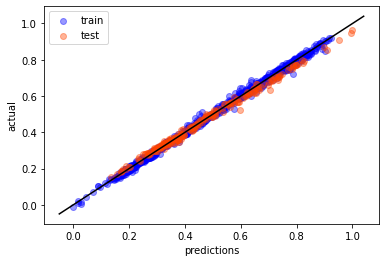

In [98]:
from sklearn import linear_model as lm
skmodel = lm.LinearRegression().fit(train_features,train_targets)
def LM(skmodel, train_features, train_targets ,test_features, test_targets):
    print('LM train', skmodel.score(train_features, train_targets))
    print('LM test', skmodel.score(test_features, test_targets))
    print('intercept = ', skmodel.intercept_, '\n', 'slope=', skmodel.coef_, '\n')
    train_predictions = skmodel.predict(train_features)
    test_predictions = skmodel.predict(test_features)
    plt.scatter(train_targets, train_predictions, label='train', alpha=0.4, color='b')
    plt.scatter(test_targets, test_predictions, label='test', alpha=0.4, color='orangered')
    #plt.scatter(targets, targets, label='Original', alpha=0.3, color='navajowhite')
    # Plot the perfect prediction line
    xmin, xmax = plt.xlim()
    plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')
    plt.xlabel('predictions')
    plt.ylabel('actual')
    plt.legend()
    plt.show()
LM(skmodel,train_features, train_targets, test_features, test_targets)


best depth 9
DTR train 0.9986900286495901
DTR test 0.8554686449204825 



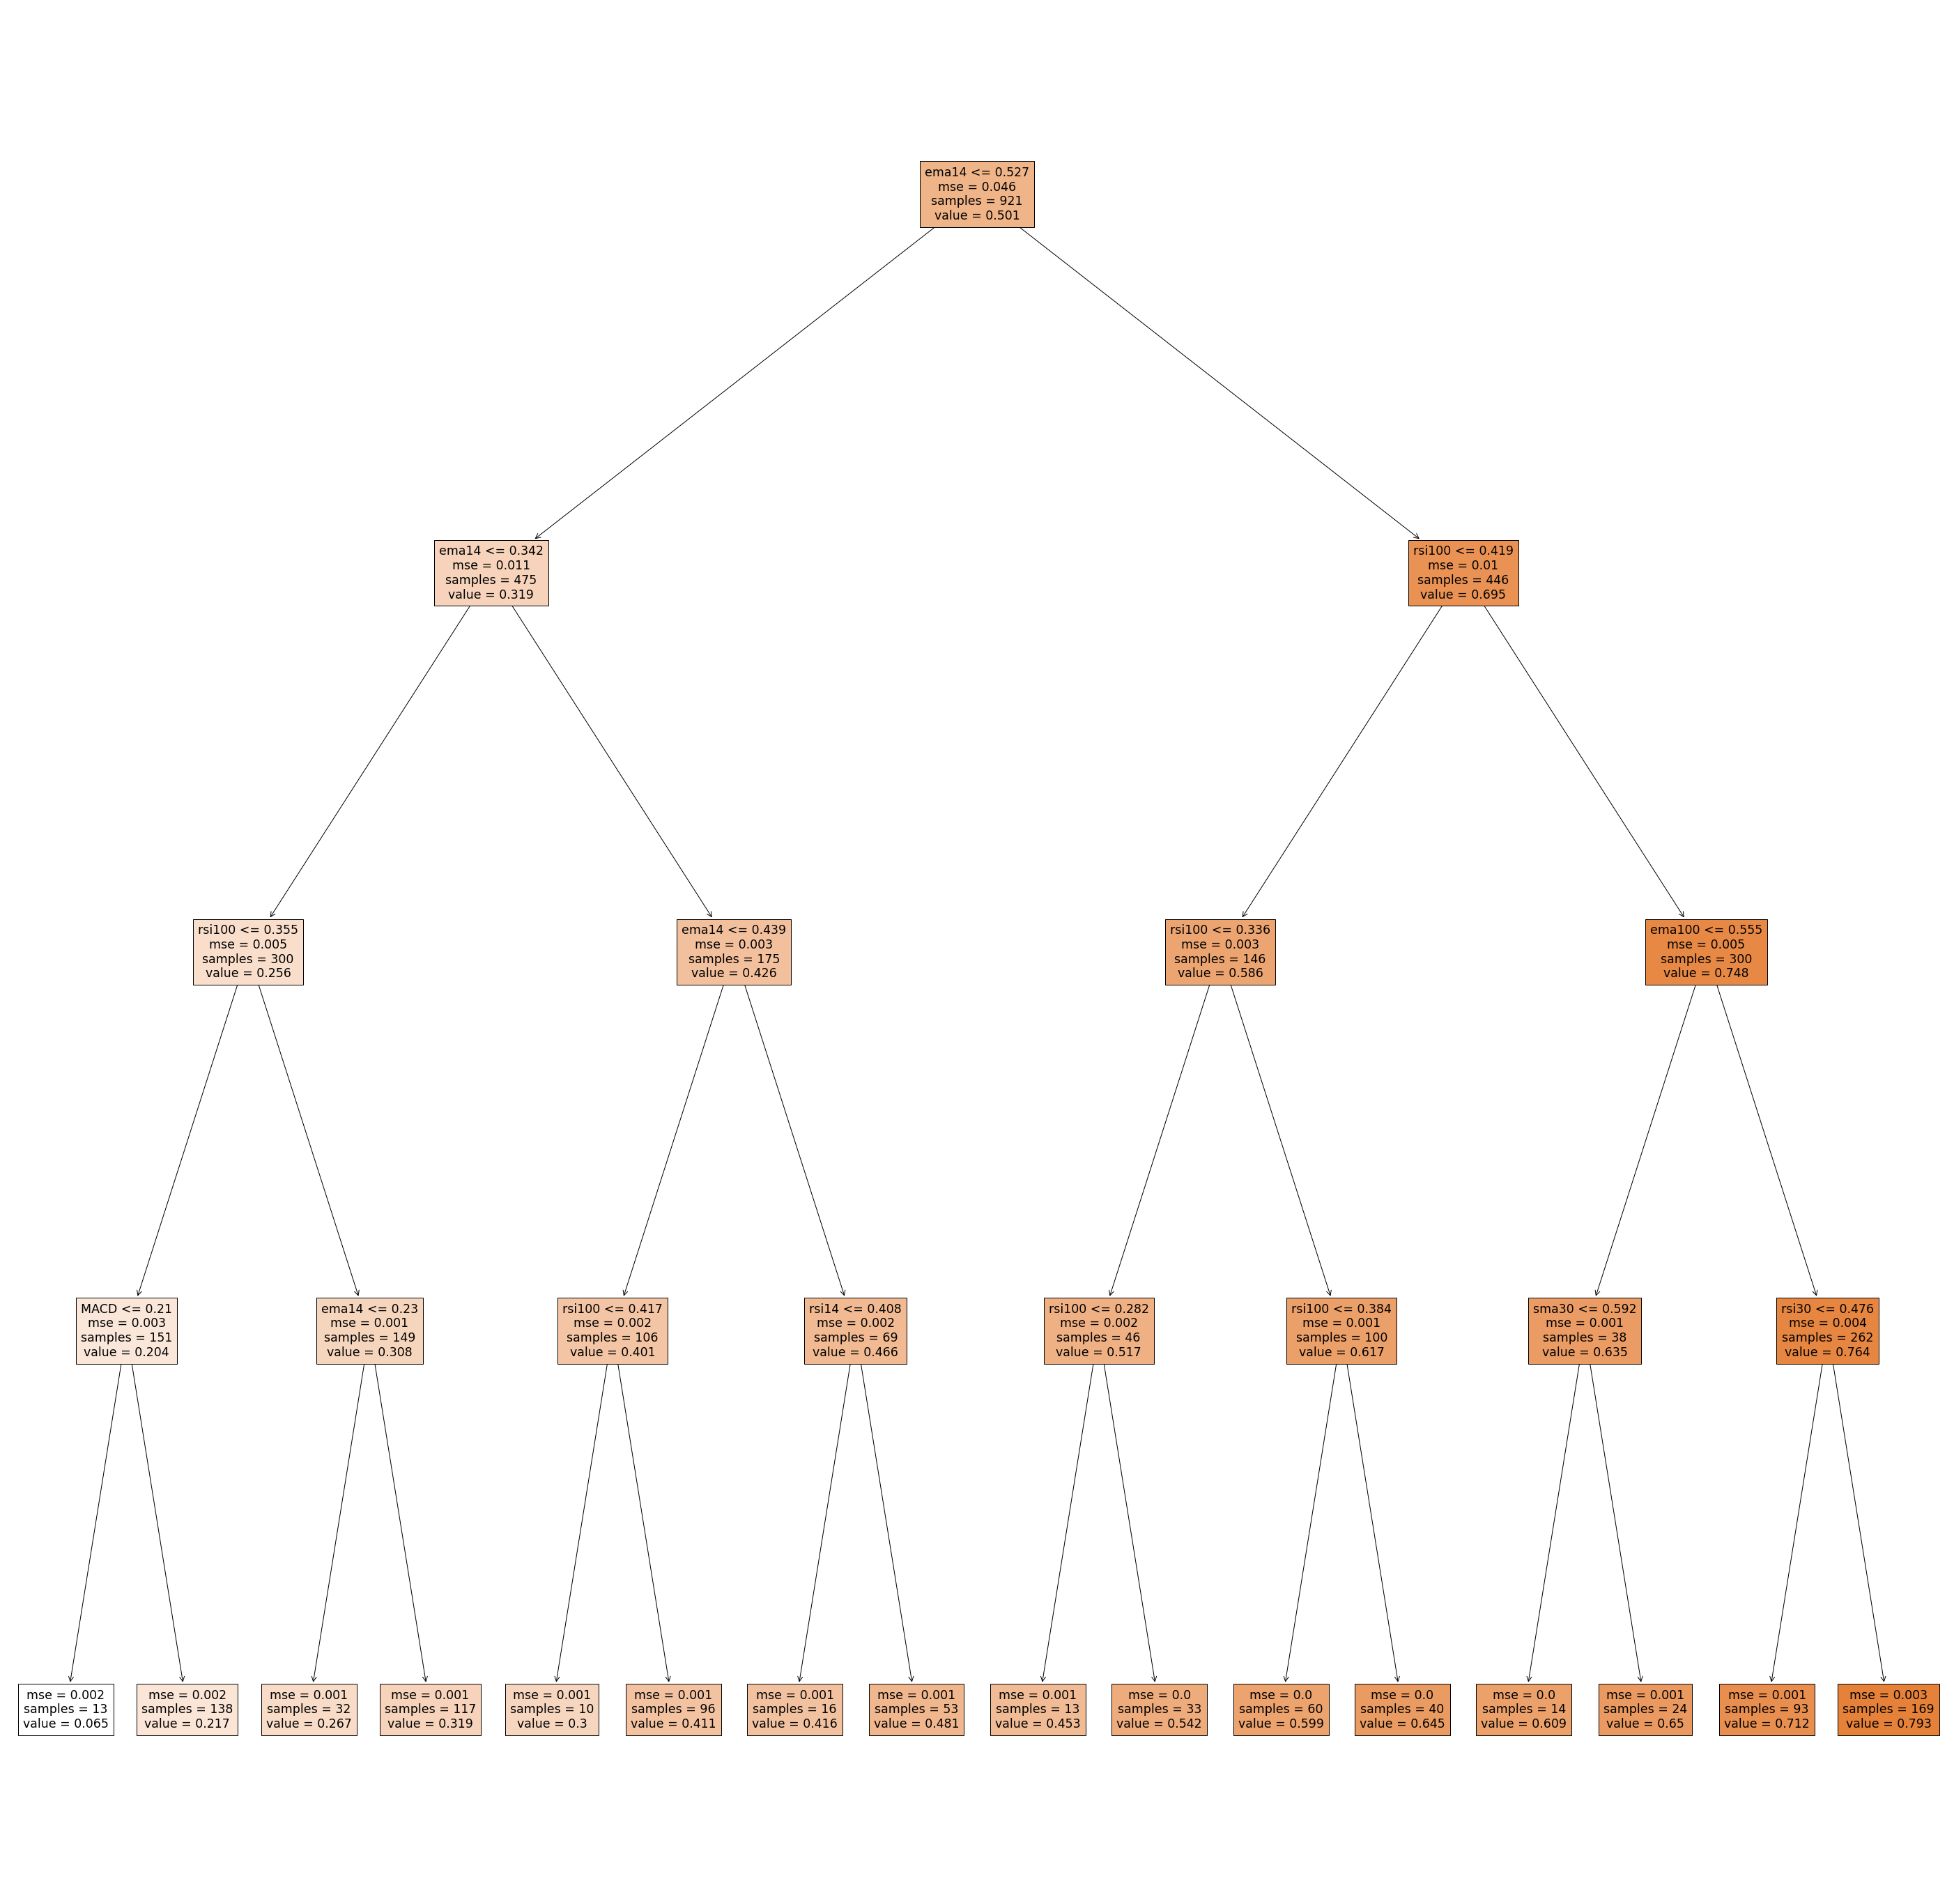

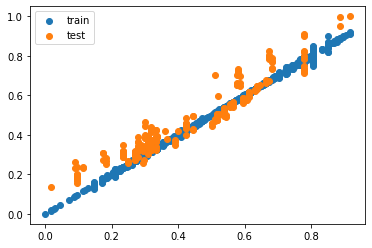

In [104]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
def DTR(train_features, train_targets, test_features, test_targets):
    score =[]
    for i in range(1, 10):
        decision_tree1 = DecisionTreeRegressor(max_depth=i)
        decision_tree1.fit(train_features, train_targets)
        score.append(decision_tree1.score(test_features, test_targets))
    print('best depth', np.argmax(score)+1)       
    decision_tree = DecisionTreeRegressor(max_depth=np.argmax(score)+1)
    decision_tree.fit(train_features, train_targets)
    print('DTR train', decision_tree.score(train_features, train_targets))
    print('DTR test', decision_tree.score(test_features, test_targets), '\n')

    plt.figure(figsize=(50, 50))
    #plot tree with 4 depth
    tree.plot_tree(DecisionTreeRegressor(max_depth=4).fit(train_features, train_targets), filled=True, feature_names=feature_names)
    plt.show()
    train_predictions = decision_tree.predict(train_features)
    test_predictions = decision_tree.predict(test_features)
    # Scatter the predictions vs actual values
    plt.scatter(train_predictions, train_targets, label='train')
    plt.scatter(test_predictions, test_targets, label='test')
    plt.legend()
    plt.show()
DTR(train_features, train_targets, test_features, test_targets)

RF train 0.9996039108025601
RF test 0.9220484870759593 



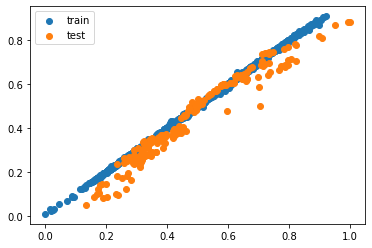

In [105]:
from sklearn.ensemble import RandomForestRegressor
def RF(train_features, train_targets, test_features, test_targets):
    rfr = RandomForestRegressor(n_estimators=200, random_state=42)
    rfr.fit(train_features, train_targets)
    # Look at the R^2 scores on train and test
    print('RF train', rfr.score(train_features, train_targets))
    print('RF test',rfr.score(test_features, test_targets), '\n')
    train_predictions = rfr.predict(train_features)
    test_predictions = rfr.predict(test_features)
    plt.scatter(train_targets, train_predictions, label='train')
    plt.scatter(test_targets, test_predictions, label='test')
    plt.legend()
    plt.show()
RF(train_features, train_targets, test_features, test_targets)

GB train 0.998702123344596
GB test 0.9666697269561563 



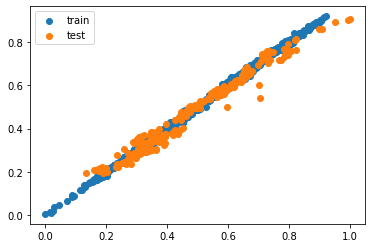

In [107]:
from sklearn.ensemble import GradientBoostingRegressor
def GB(train_features, train_targets, test_features, test_targets):
    gbr = GradientBoostingRegressor(max_features=5,
                                    random_state=42)
    gbr.fit(train_features, train_targets)
    print('GB train', gbr.score(train_features, train_targets))
    print('GB test', gbr.score(test_features, test_targets), '\n')
    train_predictions = gbr.predict(train_features)
    test_predictions = gbr.predict(test_features)
    plt.scatter(train_targets, train_predictions, label='train')
    plt.scatter(test_targets, test_predictions, label='test')
    plt.legend()
    plt.show()
GB(train_features, train_targets, test_features, test_targets)